###Importing required Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
from glob import glob
import random
from PIL import Image 
import os

In [ ]:
!pip3 install scipy==1.2.1

In [ ]:
import scipy.misc

In [ ]:
# Do not run this cell
#!pip install tensorflow-gpu==1.14.0

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
print(scipy.__version__)

1.2.1


###Helper Functions

In [ ]:
def instance_norm(inp):
    
    # variable_scope is a context manager for defining operations that creates layers (variables)
    with tf.variable_scope("instance_norm"):

        eps = 1e-5
        # for calculating mean and variance of input (inp) along axes [1,2]
        mean, var = tf.nn.moments(inp, [1,2], keep_dims=True)
        # here we will intialise two variables scale and offset for further calculations
        scale = tf.get_variable('scale', [inp.get_shape()[-1]], initializer=tf.truncated_normal_initializer(mean=1.0,stddev=0.02))
        offset = tf.get_variable('offset',[inp.get_shape()[-1]], initializer=tf.constant_initializer(0.0))
        # calculating normalisations for the Conv layer
        out = scale*tf.div(inp-mean,tf.sqrt(var+eps)) + offset
        
        return out        

###Function to define general convolution operation

In [ ]:
"""
Here input_conv is the output from previous convolution layer which acts as input for this layer
Then we have number of filters, kernel size for filters, striding, padding, standard deviation variables

This function will add single Convolution Layer if normalisation is true then it will perform Normalisation for Convolution layers
"""

def general_conv(input_conv, filters=64, kernel=7, stride=1, padding='VALID', name="conv", norm = True, stddev=0.02, relu = True, alpha = 0):
  
    # For initialising weights and bias variable of Convolution Layers
    w_init = tf.truncated_normal_initializer(mean=0.0,stddev=0.02)
    b_init = tf.constant_initializer(0.0)

    with tf.variable_scope(name):
      # Initialising Conv Layer
        conv = tf.layers.conv2d(input_conv, filters, kernel, stride, padding, kernel_initializer=w_init, bias_initializer=b_init)
        # Applying normalisation to Conv layer
        if norm == True:
            conv = instance_norm(conv)
        
        # Applying ReLu activation function
        if relu == True:
            if alpha == 0:
                conv = tf.nn.relu(conv)
            else:
                conv = tf.nn.leaky_relu(conv, alpha=alpha)
        
        return conv

###Function to define the resnet block

The following is the Diagram Representing general structure of Residual Block

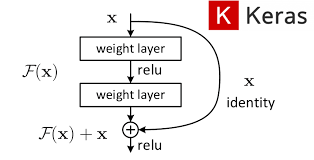

The following is the working of tf.pad() function

t = tf.constant([[1, 2, 3], [4, 5, 6]])
paddings = tf.constant([[1, 1,], [2, 2]])

// 'constant_values' is 0.

// rank of 't' is 2.

tf.pad(t, paddings, "CONSTANT")  # [[0, 0, 0, 0, 0, 0, 0],
                                 #  [0, 0, 1, 2, 3, 0, 0],
                                 #  [0, 0, 4, 5, 6, 0, 0],
                                 #  [0, 0, 0, 0, 0, 0, 0]]

tf.pad(t, paddings, "REFLECT")  # [[6, 5, 4, 5, 6, 5, 4],
                                #  [3, 2, 1, 2, 3, 2, 1],
                                #  [6, 5, 4, 5, 6, 5, 4],
                                #  [3, 2, 1, 2, 3, 2, 1]]

tf.pad(t, paddings, "SYMMETRIC")  # [[2, 1, 1, 2, 3, 3, 2],
                                  #  [2, 1, 1, 2, 3, 3, 2],
                                  #  [5, 4, 4, 5, 6, 6, 5],
                                  #  [5, 4, 4, 5, 6, 6, 5]]

In [ ]:
"""
This function is for Defining Resnet block which consist of two padding of tensor layer and two Conv layer

For Conv layer we will use the above defined function

tf.pad(tensor, paddings, mode='CONSTANT') --->
This operation pads a tensor according to the paddings you specify. paddings is an integer tensor with shape [n, 2], 
where n is the rank of tensor. For each dimension D of input, paddings[D, 0] indicates how many values to add before 
the contents of tensor in that dimension, and paddings[D, 1] indicates how many values to add after the contents of 
tensor in that dimension. If mode is "REFLECT" then both paddings[D, 0] and paddings[D, 1] must be no greater than 
tensor.dim_size(D) - 1. If mode is "SYMMETRIC" then both paddings[D, 0] and paddings[D, 1] must be no greater than 
tensor.dim_size(D).

The padded size of each dimension D of the output is:
paddings[D, 0] + tensor.dim_size(D) + paddings[D, 1]
"""

def resnet_block(input_res, filters, name="resnet"):

    with tf.variable_scope(name):
        output_res = tf.pad(input_res, [[0,0],[1,1],[1,1],[0,0]], mode="REFLECT")
        output_res = general_conv(output_res, filters=filters, kernel=3, stride=1, padding="VALID", name="c1", norm=True,stddev=0.02,relu=True)
        output_res = tf.pad(output_res, [[0,0],[1,1],[1,1],[0,0]], mode="REFLECT")
        output_res = general_conv(output_res, filters=filters, kernel=3, stride=1,padding="VALID", name="c2", norm=True, stddev=0.02, relu=False)
        
        # The final output of Residual Block will be the output of ReLu function applied to the combination of input and output of inner layers 
        return tf.nn.relu(output_res + input_res)    

###Function to define the general de-convolution operation.

In [ ]:
"""
Here input_deconv is the output from previous convolution layer which acts as input for this layer
Then we have number of filters, kernel size for filters, striding, padding, standard deviation variables

This function will add single Transpose Convolution Layer if normalisation is true then it will perform Normalisation for this layer
"""

def general_deconv(input_deconv, filters=64, kernel=7, stride=1, padding="VALID", name="deconv", norm=True, stddev=0.02, relu=True, alpha=0):

    # For initialising weights and bias variable of Convolution Layers
    w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)

    with tf.variable_scope(name):
        # Initialising Conv Layer
        conv = tf.layers.conv2d_transpose(input_deconv, filters, kernel, stride, padding, kernel_initializer=w_init, bias_initializer=b_init)
        
        # Applying normalisation to Conv layer
        if norm == True:
            conv = instance_norm(conv)
        
        # Applying ReLu activation function
        if relu == True:
            if alpha == 0:
                conv = tf.nn.relu(conv)
            else:
                conv = tf.nn.leaky_relu(conv, alpha=alpha)

        return conv

##Architecture of Model

####Till now we have defined all the layers which we will need for modelling the Architecture of our GAN and now we will define Model in the same way as discussed in the Original Paper of CycleGAN

###Generator Architecture with 6 ResNet blocks as described in CycleGAN Paper.

Example of Architecture of Generator of CycleGAN

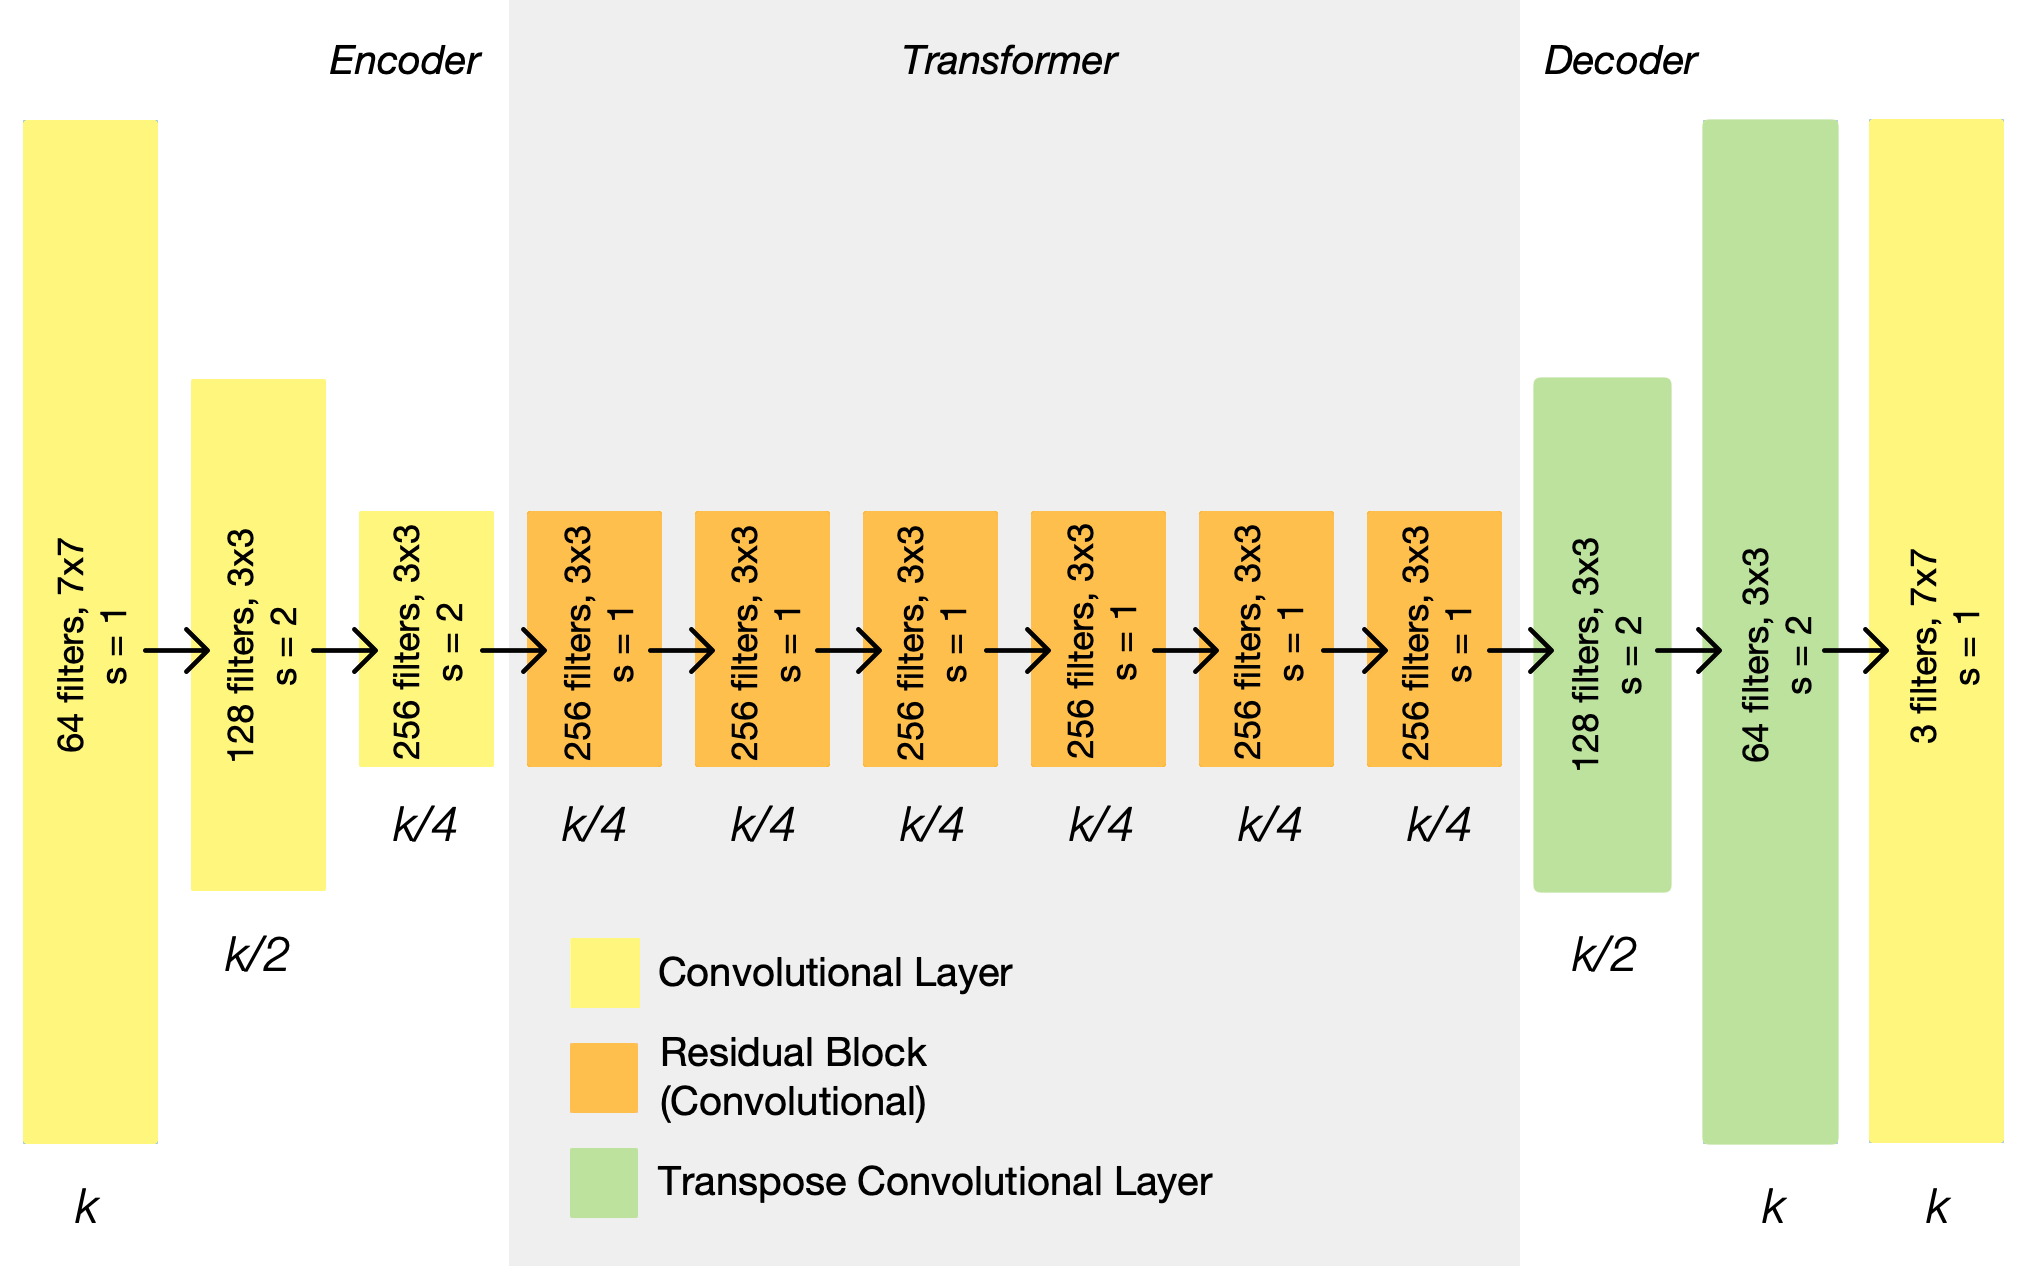

Here we are not taking the exact same Architecture we have reduced all the filters to half because of the limited Computational Strength

In [ ]:
"""
This function is for defining the architecture of the Generator Model of the CycleGAN

The Architecture is similar to the above diagram
"""

def generator(input_gen, name='generator'):

    with tf.variable_scope(name):
        # Applying Padding to the input_gen
        pad_input = tf.pad(input_gen, [[0,0],[3,3],[3,3],[0,0]], mode="REFLECT")
        
        # Adding the Conv layers for the Encoder part of Generator

        # First Layer -> 32 filters of 7x7 (kernel = 7)
        d32 = general_conv(pad_input, filters=32, kernel=7, stride=1, padding='VALID', name="conv1", norm=True, stddev=0.02, relu=True)

        # Second Layer -> 64 filters of 3x3 (kernel = 3)
        d64 = general_conv(d32, filters=64, kernel=3, stride=2, padding="SAME", name="conv2", norm=True, stddev=0.02, relu=True)

        # Third Layer -> 128 filters of 3x3 (kernel = 3)
        d128 = general_conv(d64, filters=128, kernel=3, stride=2, padding="SAME", name="conv3", norm=True, stddev=0.02, relu=True)
        
        # Adding the ResNet blocks with 128 filters each and we have defined the kernel = 3 and stride = 1 in Resnet_block function
        R128_1 = resnet_block(d128, filters=128, name="r1")
        R128_2 = resnet_block(R128_1, filters=128, name="r2")
        R128_3 = resnet_block(R128_2, filters=128, name="r3")
        R128_4 = resnet_block(R128_3, filters=128, name="r4")
        R128_5 = resnet_block(R128_4, filters=128, name="r5")
        R128_6 = resnet_block(R128_5, filters=128, name="r6")
        
        # Now Adding Deconv layers for the Decoder part of Generator

        # First Layer -> 64 filters of 3x3 (kernel = 3)
        u64 = general_deconv(R128_6, filters=64, kernel=3, stride=2, padding="SAME", name="dc1", norm=True, stddev=0.02, relu=True)

        # Second Layer -> 32 filters of 3x3 (kernel = 3)
        u32 = general_deconv(u64, filters=32, kernel=3, stride=2, padding="SAME", name="dc2", norm=True, stddev=0.02, relu=True)
        
        # Adding padding to the output
        u32_pad = tf.pad(u32, [[0,0],[3,3],[3,3],[0,0]], mode="REFLECT")
        
        # Adding the last layer to the Decoder of 3 filter of 7x7
        c7s1_3 = general_conv(u32_pad, filters=3, kernel=7, stride=1, padding="VALID", name="conv4", norm=True, stddev=0.02,relu=False)
        
        output_gen = tf.nn.tanh(c7s1_3,"out_gen")
        
        return output_gen

###Discriminator Architecture as described in CycleGAN paper.

Example of Architecture of Discriminator of CycleGAN

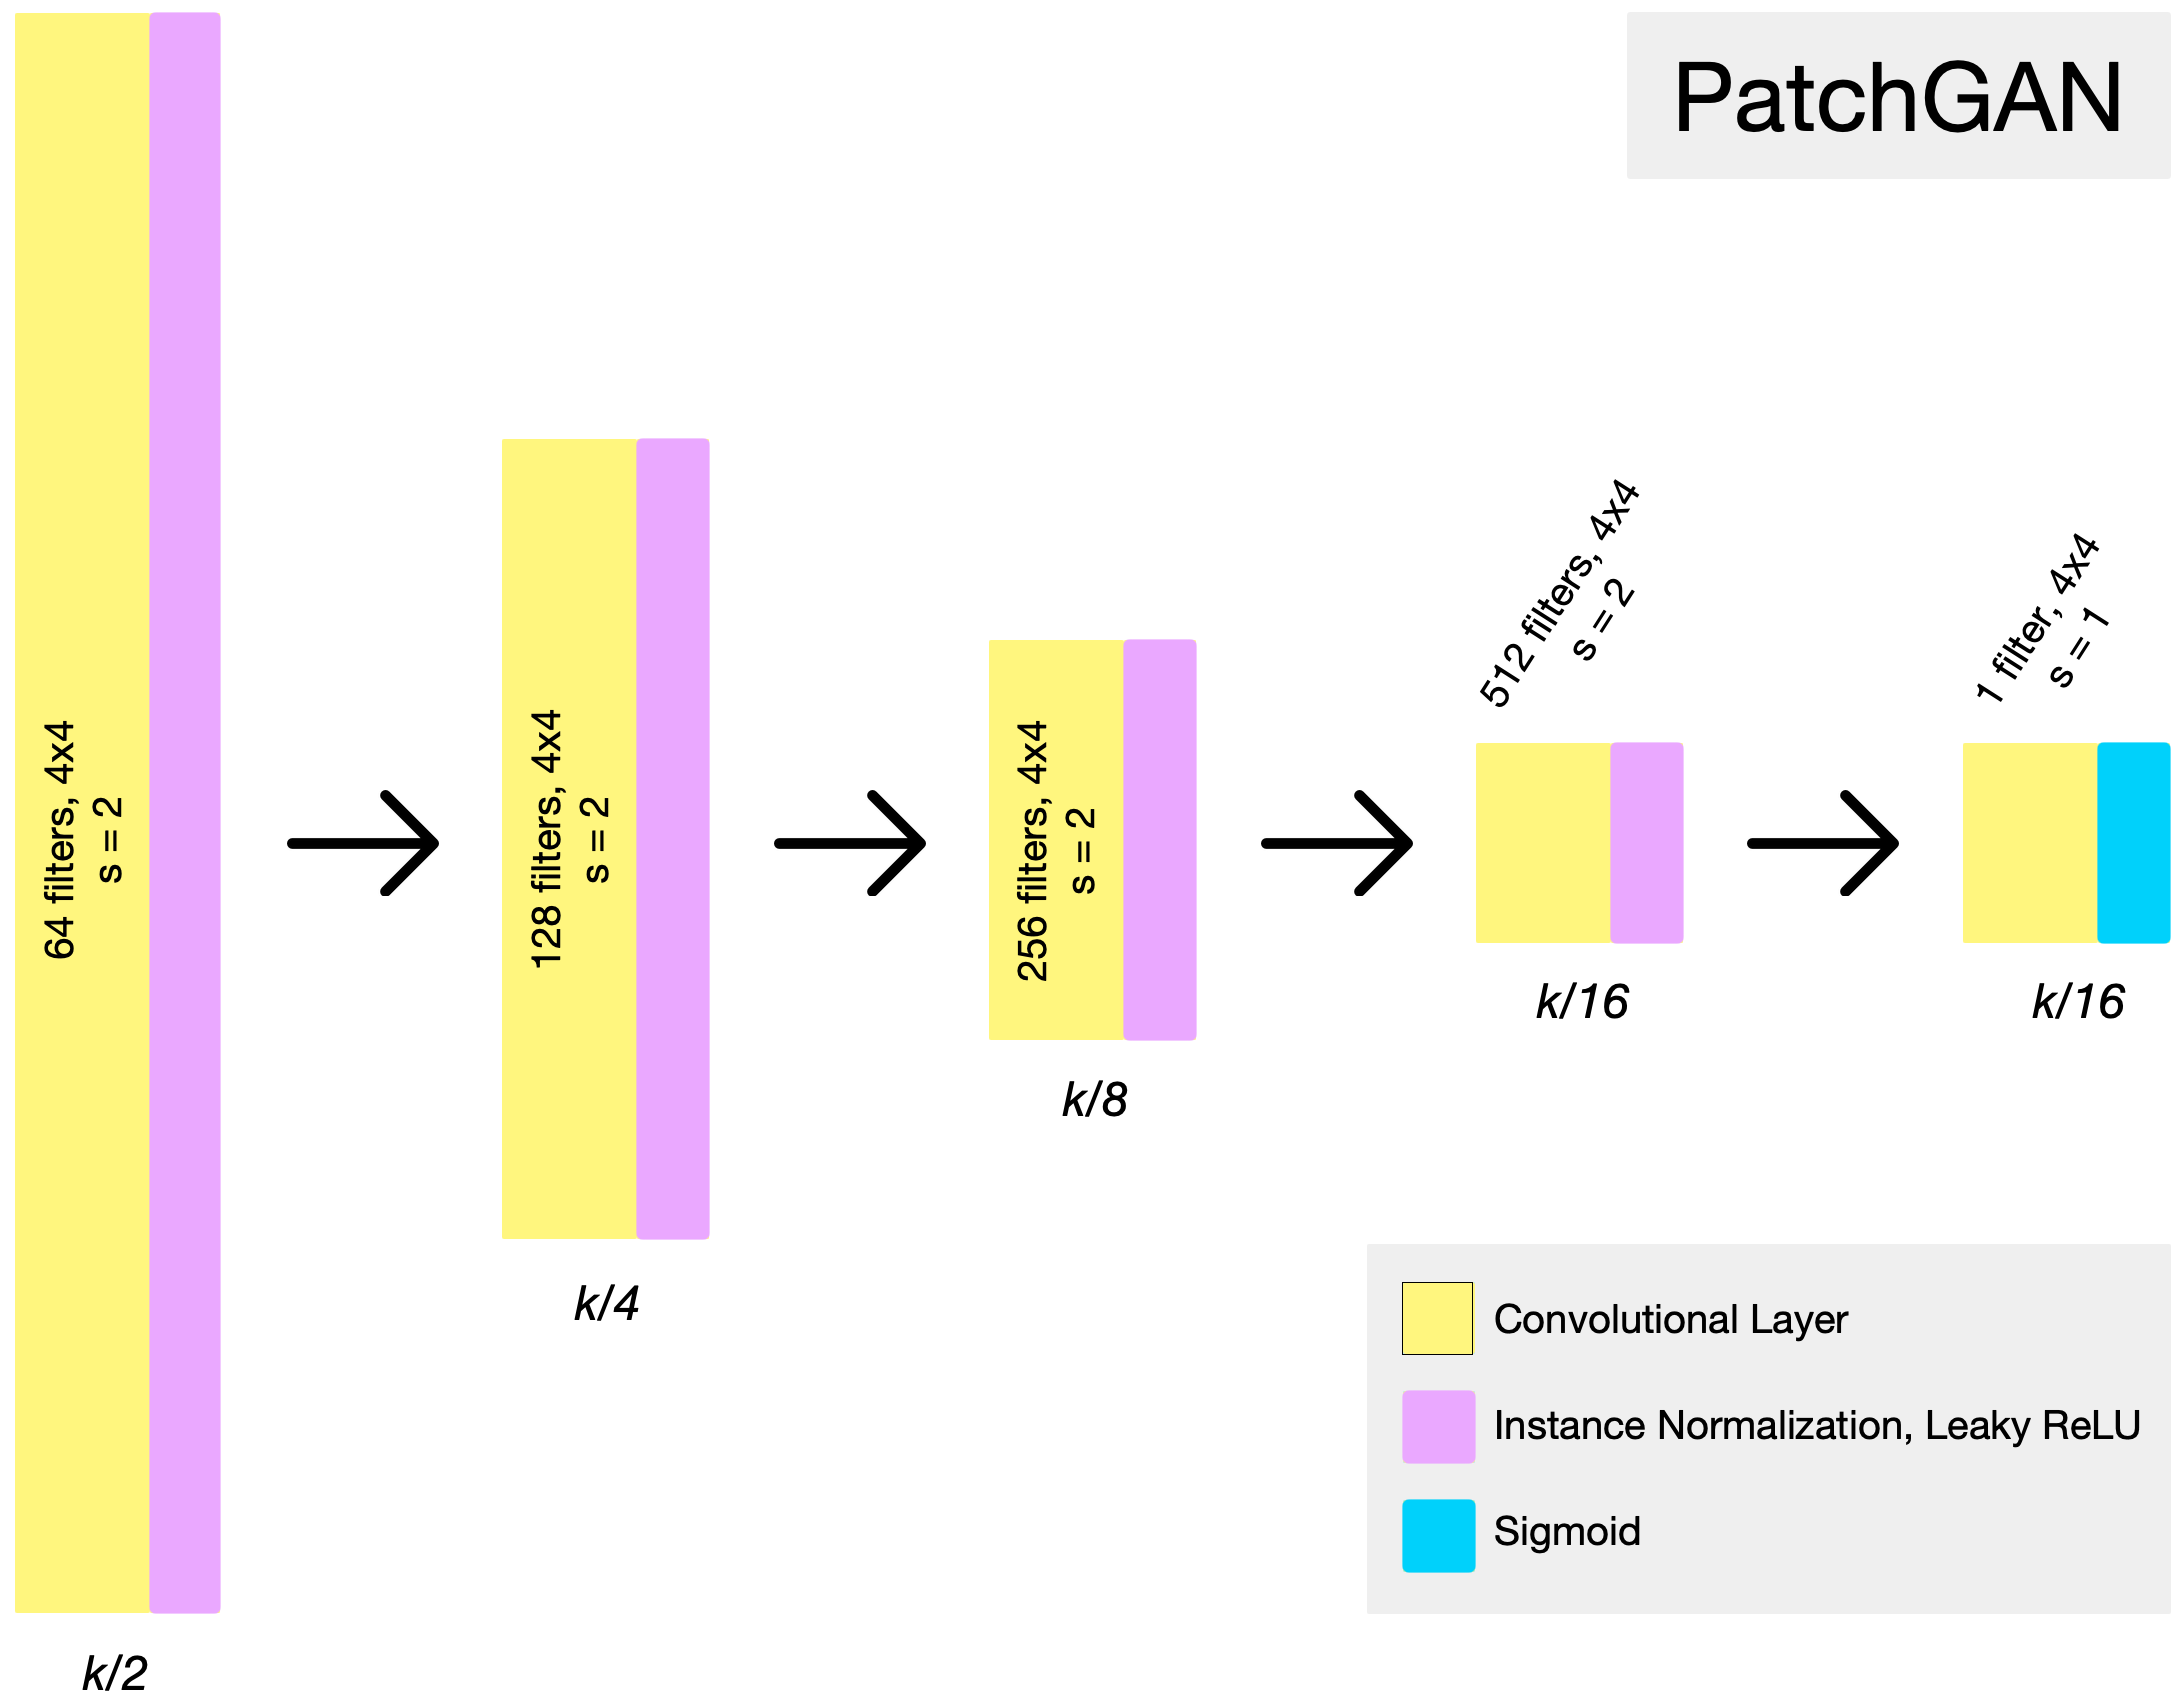

In [ ]:
""" 
This function is for defining the architecture of the Discriminator Model of the CycleGAN

The Architecture is similar to the above diagram
"""

def discriminator(input_disc,name="discriminator"):

    with tf.variable_scope(name):
        
        # Adding the Conv layers for the Model

        # First layer -> 64 filters of 4x4
        C64 = general_conv(input_disc, filters=64, kernel=4, stride=2, padding="SAME", name="c1", norm=False, relu=True, alpha=0.2)

        # Second layer -> 128 filters of 4x4
        C128 = general_conv(C64, filters=128, kernel=4, stride=2, padding="SAME", name="c2", norm=True, stddev=0.02,relu=True, alpha=0.2)

        # Third layer -> 256 filters of 4x4
        C256 = general_conv(C128, filters=256, kernel=4, stride=2, padding="SAME", name="c3", norm=True, stddev=0.02,relu=True, alpha=0.2)

        # Fourth layer -> 512 filters of 4x4
        C512 = general_conv(C256, filters=512, kernel=4, stride=2, padding="SAME", name="c4", norm=True, stddev=0.02,relu=True, alpha=0.2)

        # Adding the final layer with 1 filter of 4x4
        logits = general_conv(C512, filters=1, kernel=4, stride=1, padding="SAME", name="disc_logits", norm=False, relu=False)

        return logits    

###Class Definition of CycleGAN as presented in paper by Zhu et. al.

####Till now we have made the Architecture of the CycleGAN and now we will define the inputs to model, loss function and optimization function for the Model

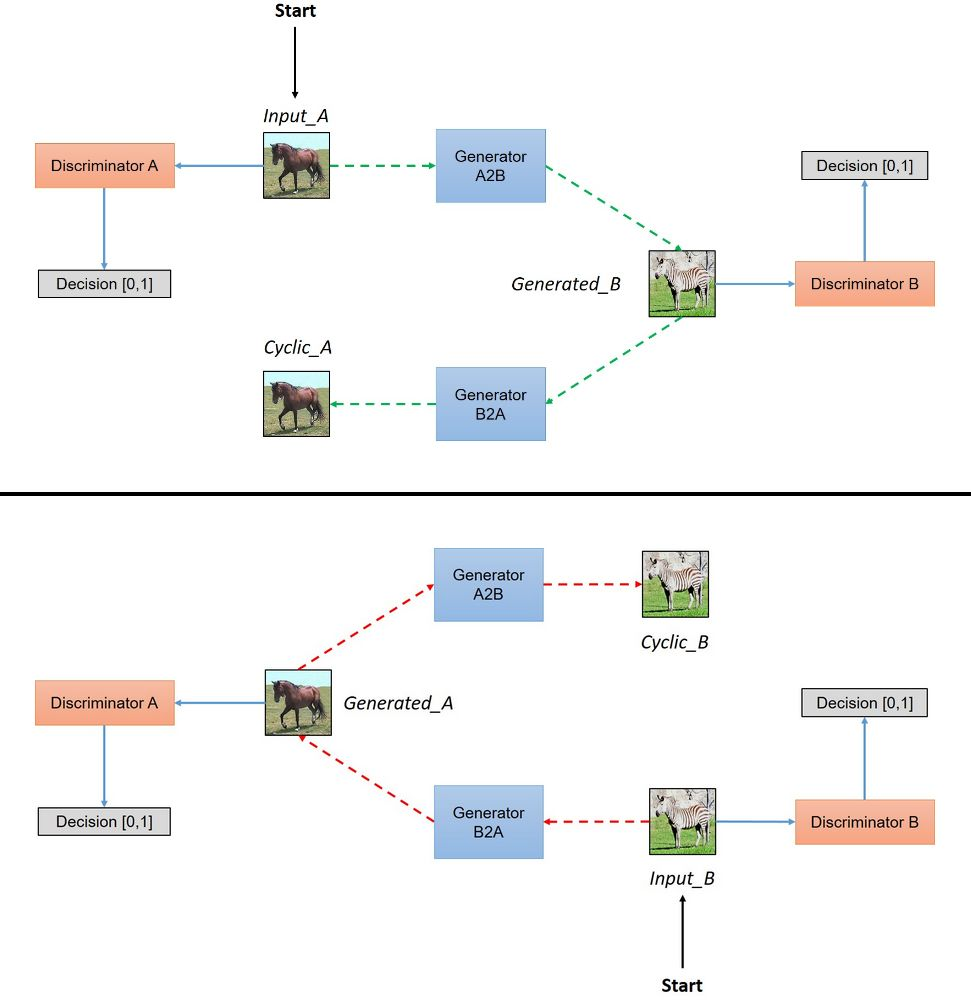

In [ ]:
class CycleGAN:
    
    def __init__(self, batch_size, input_shape, pool_size, beta1):

        """
        Defining the required variables
        """
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.pool_size = pool_size
        # Defining Learning Rate as a placeholder 
        self.lr_rate = tf.placeholder(dtype=tf.float32, shape=[], name="lr_rate")

        # Defining the shapes for inputs to both the Generators ... Calling the model_input fucntion
        self.input_A, self.input_B, self.fake_pool_Aimg, self.fake_pool_Bimg = self.model_inputs(self.batch_size, self.input_shape[0], self.input_shape[1], self.input_shape[2])
        
        # Calling the model_arc function  
        self.gen_A, self.gen_B, self.cyclicA, self.cyclicB, self.real_disc_A, self.real_disc_B, self.fake_disc_A, self.fake_disc_B, self.fake_pool_disc_A, self.fake_pool_disc_B = self.model_arc(self.input_A, self.input_B, self.fake_pool_Aimg, self.fake_pool_Bimg)
        
        # Calling the model_loss function
        self.gen_loss_A, self.disc_loss_A, self.gen_loss_B,self.disc_loss_B = self.model_loss(self.real_disc_A, self.real_disc_B, self.fake_disc_A, self.fake_disc_B, self.fake_pool_disc_A, self.fake_pool_disc_B, self.input_A, self.cyclicA, self.input_B, self.cyclicB)
        
        # Calling the model_opti function
        self.discA_opt, self.discB_opt, self.genA_opt, self.genB_opt = self.model_opti(self.gen_loss_A, self.disc_loss_A, self.gen_loss_B, self.disc_loss_B, self.lr_rate, beta1)
        
        
    """
    Function to model inputs of the network
    """
    def model_inputs(self, batch_size, height, width, channels):
        
        # Defining Placeholders for the shapes of Input data
        input_A = tf.placeholder(dtype=tf.float32, shape=[batch_size,width,height,channels], name="input_A")
        input_B = tf.placeholder(dtype=tf.float32, shape=[batch_size,width,height,channels], name="input_B")         
        gen_pool_A = tf.placeholder(dtype=tf.float32, shape=[batch_size,width,height,channels], name="fake_pool_Aimg") 
        gen_pool_B = tf.placeholder(dtype=tf.float32, shape=[batch_size,width,height,channels], name="fake_pool_Bimg") 
        
        return input_A, input_B, gen_pool_A, gen_pool_B
    

    """
    Function to model architecture of CycleGAN. 
    """
    def model_arc(self, input_A, input_B, fake_pool_A, fake_pool_B):
        
        with tf.variable_scope("CycleGAN") as scope:

            # Input is given to the Generator A (Horse photo to GEN A2B) and output will be fed to Discriminator B and Generator B
            gen_B = generator(input_A, name="generator_A")

            # Input is given to the Generator B (Zebra photo to GEN B2A) and output will be fed to Discriminator A and Generator A
            gen_A = generator(input_B, name="generator_B")

            # Input is given to the Discriminator A (Horse photo to Discriminator A) 
            real_disc_A = discriminator(input_A, name="discriminator_A")

            # Input is given to the Discriminator B (Zebra photo to Discriminator B) 
            real_disc_B = discriminator(input_B, name="discriminator_B")
            
            scope.reuse_variables()
            
            # Output of Generator B is given as input to the Discriminator A (Generated Horse image from input Zebra image to GenB2A is 
            # passed as input to Discriminator A)
            fake_disc_A = discriminator(gen_A, name="discriminator_A")

            # Output of Generator A is given as input to the Discriminator B (Generated Zebra image from input Horse image to GenA2B is 
            # passed as input to Discriminator B)
            fake_disc_B = discriminator(gen_B, name="discriminator_B")
            
            # Output of Generator A is given as input to Generator B (Generated Zebra image from input Horse image to GenA2B is
            # passed as input to GenB2A)
            cyclicA = generator(gen_B, name="generator_B")

            # Output of Generator B is given as input to Generator A (Generated Horse image from input Zebra image to GenB2A is
            # passed as input to GenA2B)
            cyclicB = generator(gen_A, name="generator_A")
            
            scope.reuse_variables()
            
            # Now we will pass the Random fake image of Horse to the Discriminator A and similarly fake image of Zebra to Discriminator B
            # We already passed the real input image of Horse to Discriminator A and of Zebra to Discriminator B
            fake_pool_disc_A = discriminator(fake_pool_A, name="discriminator_A")
            fake_pool_disc_B = discriminator(fake_pool_B, name="discriminator_B")
            
            # The difference in fake_disc_A and fake_pool_disc_A is that fake_disc_A is same as that of real_disc_A that is both are for 
            # same set of inputs on input_A and input_B but the fake_pool_disc_A is completly random choosen image that is present in pool

            return gen_A,gen_B,cyclicA,cyclicB,real_disc_A,real_disc_B,fake_disc_A,fake_disc_B,fake_pool_disc_A,fake_pool_disc_B
        
    
    """
    Function to calculate loss.
    """    
    def model_loss(self,real_disc_A,real_disc_B,fake_disc_A,fake_disc_B,fake_pool_disc_A,fake_pool_disc_B,input_A,cyclicA,input_B,cyclicB):
        
        # This is cyclic loss for the Images generated by both the Generators
        # loss when input Horse image to GenA and then output Horse from GenB
        # similarly loss when input Zebra image to GenB and then output Zebra from GenA
        cyclic_loss = tf.reduce_mean(tf.abs(input_A - cyclicA)) + tf.reduce_mean(tf.abs(input_B - cyclicB))
        
        # This is the loss of both the Discriminators for predicting on the Generated images that is
        # similar to DCGAN implementation fake image is passed as real image label therefore L2 loss with 1 is calculated
        # Horse ---> Zebra now prediction on Zebra
        # Zebra ---> Horse now prediction on Horse
        disc_loss_A = tf.reduce_mean(tf.squared_difference(fake_disc_A,1))
        disc_loss_B = tf.reduce_mean(tf.squared_difference(fake_disc_B,1))
        
        # This is Generator Loss, Combining both the losses
        gen_loss_A = cyclic_loss*10 + disc_loss_B
        gen_loss_B = cyclic_loss*10 + disc_loss_A
        
        # This is the loss of Discriminators 
        # It is combination of both real_disc_A and fake_pool_disc_A
        # similar to DCGAN implementation fake image is passed as fake image label therefore L2 loss with 0 is calculated
        # and real image is passed as real image label therfore L2 loss with 1 is calculated
        d_loss_A = (tf.reduce_mean(tf.square(fake_pool_disc_A)) + tf.reduce_mean(tf.squared_difference(real_disc_A,1)))/2.0
        d_loss_B = (tf.reduce_mean(tf.square(fake_pool_disc_B)) + tf.reduce_mean(tf.squared_difference(real_disc_B,1)))/2.0

        return gen_loss_A, d_loss_A, gen_loss_B, d_loss_B
    

    """
    Function to optimize the network. Used Adam Optimizer.
    """
    def model_opti(self, gen_loss_A, disc_loss_A, gen_loss_B, disc_loss_B, lr_rate, beta1):
        
        # Separating all the variables for their updation 
        train_vars = tf.trainable_variables()
        discA_vars = [var for var in train_vars if var.name.startswith('CycleGAN/discriminator_A')]
        discB_vars = [var for var in train_vars if var.name.startswith('CycleGAN/discriminator_B')]
        genA_vars = [var for var in train_vars if var.name.startswith('CycleGAN/generator_A')]        
        genB_vars = [var for var in train_vars if var.name.startswith('CycleGAN/generator_B')]        
        
        # Optimizing the variables
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):

            # Applying ADAM Optimizer and minimizing the given loss by updating the var_list
            discA_train_opt = tf.train.AdamOptimizer(lr_rate, beta1=beta1).minimize(disc_loss_A, var_list = discA_vars)
            discB_train_opt = tf.train.AdamOptimizer(lr_rate, beta1=beta1).minimize(disc_loss_B, var_list = discB_vars)
            genA_train_opt = tf.train.AdamOptimizer(lr_rate, beta1=beta1).minimize(gen_loss_A, var_list = genA_vars)
            genB_train_opt = tf.train.AdamOptimizer(lr_rate, beta1=beta1).minimize(gen_loss_B, var_list = genB_vars)
    
        return discA_train_opt, discB_train_opt, genA_train_opt, genB_train_opt
        
    

###Training Process

####Till now we have defined our Model Architecture and Optimizing functions now we will Train our Model

In [ ]:
"""
This Function is for getting path of image and width and height of Image.
"""
def get_image_new(image_path, width, height):

    image = Image.open(image_path)
    # Image.BILINEAR is for 2x2 linear interpolation
    image = image.resize([width, height], Image.BILINEAR)
    image = np.array(image, dtype=np.float32)

    # Normalisation Steps
    image = np.divide(image,255) 
    image = np.subtract(image,0.5)
    image = np.multiply(image,2)

    return image

In [ ]:
"""
This function is for making Pools of Imgaes for passing these Images to Generators

Generated Zebra image from input Horse image by GenA will be saved in poolB (for Zebra images)

Generated Horse image from input Zebra image by GenB will be saved in poolA (for Horse images)
"""

def save_to_pool(poolA, poolB, gen_A, gen_B, pool_size, num_im):
      
        # Number of Images is less than pool size directly enter the images
        if num_im < pool_size:
            poolA[num_im] = gen_A
            poolB[num_im] = gen_B
        
        # Else select a random Image from Pool and replace it with new Image
        else:
            p = random.random()
            if p > 0.5:
                indA = random.randint(0,pool_size-1)
                poolA[indA] = gen_A
            
            p = random.random()
            if p > 0.5: 
                indB = random.randint(0,pool_size-1)
                poolB[indB] = gen_B
        
        num_im = num_im + 1

        return poolA, poolB, num_im

In [ ]:
def train(cgan_net, max_img, batch_size, trainA, trainB, lr_rate, shape, pool_size, model_dir, images_dir):

    saver = tf.train.Saver(max_to_keep=None)
    lenA = len(trainA)
    lenB = len(trainB)
    epoch = 1
    countA = 0 
    countB = 0
    num_imgs = 0
    # Shape = 256x256x3
    poolA = np.zeros((pool_size,1,shape[0],shape[1],shape[2]))
    poolB = np.zeros((pool_size,1,shape[0],shape[1],shape[2]))

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        # Number of Epochs = 200
        """
        Here in each epoch we will have 250 steps that is in each epoch we will take only 250 image pairs (A, B)
        Once we complete whole Train Set we will shuffle the data and will start again...
        We will print info after each 50 steps
        We will save the generated images after every 150 steps
        We will save model weights after every 50 epochs...
        """
        while epoch <= 200:
          # For gradual decreasing the Learning Rate to avoid Overfitting and ensure better learning
            if epoch >= 100:
                lr_rate = 0.0002 - ((epoch-100)*0.0002)/100
            
            for step in range(max_img):
                
                if countA >= lenA:
                    countA = 0
                    random.shuffle(trainA)
                
                if countB >= lenB:
                    countB = 0
                    random.shuffle(trainB)
                
                # for getting Image from trainA folder for Input to Generator
                imgA = get_image_new(trainA[countA],shape[0],shape[1])
                countA = countA + 1
                # for getting Image from trainB folder for Input to Generator
                imgB = get_image_new(trainB[countB],shape[0],shape[1])
                countB = countB + 1
                
                imgA = np.reshape(imgA,(1,shape[0],shape[1],shape[2]))
                imgB = np.reshape(imgB,(1,shape[0],shape[1],shape[2]))
               
                # These all are the values associated with the Instance of CycleGAN Class
                # Here we are passing one single image imgA as an input to GenA (input_A) and single image imgB as an input to GenB (input_B)
                # along with learning rate and we are getting all these values as output 
                gen_A_opt, genB, genA_loss, gen_B_opt, genA, genB_loss, cyclicA, cyclicB = sess.run([cgan_net.genA_opt, cgan_net.gen_B, cgan_net.gen_loss_A, cgan_net.genB_opt, cgan_net.gen_A, cgan_net.gen_loss_B, cgan_net.cyclicA, cgan_net.cyclicB],feed_dict={cgan_net.input_A:imgA, cgan_net.input_B:imgB, cgan_net.lr_rate:lr_rate})
                
                # Saving the generated Images like
                # Zebra from input Horse through GenA and Horse from input Zebra through GenB
                poolA, poolB, num_imgs = save_to_pool(poolA, poolB, genA, genB, pool_size, num_imgs)
                
                
                indA = random.randint(0,(min(pool_size,num_imgs)-1))
                indB = random.randint(0,(min(pool_size,num_imgs)-1))

                # Selecting a generated image 
                # Generated Zebra images from GenA and Generated Horse images from GenB
                fakeA_img = poolA[indA]
                fakeB_img = poolB[indB]
                
                # Now passing actual images of Horse and Zebra (imgA and imgB) alongwith
                # generated fake images of them (fakeA_img and fakeB_img) and observing the loss of Discriminator
                _, discA_loss,_, discB_loss = sess.run([cgan_net.discA_opt, cgan_net.disc_loss_A, cgan_net.discB_opt, cgan_net.disc_loss_B],feed_dict={cgan_net.input_A:imgA, cgan_net.input_B:imgB, cgan_net.lr_rate:lr_rate, cgan_net.fake_pool_Aimg:fakeA_img, cgan_net.fake_pool_Bimg:fakeB_img})
                
                
                
                if step % 50 == 0:
                    print ("epoch = %r step = %r discA_loss = %r genA_loss = %r discB_loss = %r genB_loss = %r" 
                           %(epoch,step,discA_loss,genA_loss,discB_loss,genB_loss))
                    
                if step % 150 == 0:
                    images = [genA, genB, cyclicA, cyclicB]
                    img_ind = 0

                    for img in images:
                        img = np.reshape(img,(shape[0],shape[1],shape[2]))
                        # for converting the normalised pixel values back to original pixel values
                        if np.array_equal(img.max(), img.min()) == False:
                            img = (((img - img.min())*255)/(img.max()-img.min())).astype(np.uint8)
                        else:
                            img = ((img - img.min())*255).astype(np.uint8)
                        scipy.misc.toimage(img, cmin=0.0, cmax=...).save(images_dir+"Epoch_"+str(epoch)+"_step_"+str(step)+"_img_"+str(img_ind)+".jpg")
                        img_ind = img_ind + 1
                        
                #print ("step = %r" %(step))
                
            if epoch % 50 == 0:
                saver.save(sess, model_dir+"try_epoch_"+str(epoch)+"\\", write_meta_graph=True)
                print ("### Model weights Saved epoch = %r ###" %(epoch))
            
            epoch = epoch + 1

###Defining the Paths

In [ ]:
data_path = "/content/drive/My Drive/Colab Notebooks/GAN/Monet Photo Editing/monet2photo" 
input_fname_pattern = "*.jpg"
model_dir = "/content/drive/My Drive/Colab Notebooks/GAN/Monet Photo Editing/saved_model/" 
sampled_images_dir = "/content/drive/My Drive/Colab Notebooks/GAN/Monet Photo Editing/saved_images/"

###Training

In [ ]:
# Extracting the Training Sets
trainA = glob(data_path+"/trainA/"+input_fname_pattern)
trainB = glob(data_path+"/trainB/"+input_fname_pattern)

# Defining the Hyper parameters
input_shape = 256,256,3
batch_size = 1
pool_size = 50 
lr_rate = 0.0002
beta1 = 0.5
max_img = 250
#tf.reset_default_graph()
        
# Defining the MOdel
cgan_net = CycleGAN(batch_size,input_shape,pool_size,beta1)
        
# Calling the train function
train(cgan_net,max_img,batch_size,trainA,trainB,lr_rate,input_shape,pool_size,model_dir,sampled_images_dir)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:1294: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  warnings.warn('`tf.layers.conv2d_transpose` is deprecated and '


epoch = 1 step = 0 discA_loss = 1.3823168 genA_loss = 16.350454 discB_loss = 2.730698 genB_loss = 14.605027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning:     `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.


epoch = 1 step = 50 discA_loss = 0.3927518 genA_loss = 11.6080475 discB_loss = 0.5145524 genB_loss = 11.467846
epoch = 1 step = 100 discA_loss = 0.3863646 genA_loss = 5.6333137 discB_loss = 0.17161095 genB_loss = 5.505925
epoch = 1 step = 150 discA_loss = 0.4023346 genA_loss = 9.515219 discB_loss = 0.24416584 genB_loss = 9.540944
epoch = 1 step = 200 discA_loss = 0.500871 genA_loss = 7.365126 discB_loss = 0.3885008 genB_loss = 7.2257423
epoch = 2 step = 0 discA_loss = 0.100517206 genA_loss = 7.169431 discB_loss = 0.21643306 genB_loss = 7.1668
epoch = 2 step = 50 discA_loss = 0.49353847 genA_loss = 5.477239 discB_loss = 0.16265005 genB_loss = 5.276049
epoch = 2 step = 100 discA_loss = 0.062631175 genA_loss = 7.648369 discB_loss = 0.20707965 genB_loss = 7.6026554
epoch = 2 step = 150 discA_loss = 0.44505757 genA_loss = 7.5643373 discB_loss = 0.17444366 genB_loss = 7.3837805
epoch = 2 step = 200 discA_loss = 0.3123932 genA_loss = 5.2417436 discB_loss = 0.21525878 genB_loss = 5.2941923
epo